# rent回归模型

In [1]:
import pandas as pd
import numpy as np
import re
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import jieba
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os

In [2]:
train_rent = pd.read_csv('ruc_Class25Q2_train_rent.csv', low_memory=False)    # 租赁训练集 low_memory=False可以一次读取整个文件而不是分块读取
test_rent = pd.read_csv('ruc_Class25Q2_test_rent.csv', low_memory=False)      # 租赁测试集

## step1 数据处理

### 前置准备+删去一些行和列

In [3]:
rent_stats = {
    'facility_keywords': ['冰箱', '床', '暖气', '宽带', '天然气', '洗衣机', '空调', '热水器', '衣柜', '电视']
}

In [4]:
"""删除训练集中缺失值过多的行（缺失25个及以上特征的行）"""
print("删除高缺失值行之前训练集形状:", train_rent.shape)

# 计算每行的缺失值数量
row_missing_counts = train_rent.isnull().sum(axis=1) # insnull检测每个元素是否为缺失值 axis=1是按行求和

# 找出缺失25个及以上特征的行
high_missing_rows = row_missing_counts[row_missing_counts >= 25]
print(f"缺失25个及以上特征的行数: {len(high_missing_rows)}")

if len(high_missing_rows) > 0:
    # 删除这些行
    train_rent = train_rent.drop(high_missing_rows.index)
    
    print(f"删除高缺失值行之后训练集形状: {train_rent.shape}")
    print(f"共删除了 {len(high_missing_rows)} 行数据")
else:
    print("没有发现缺失25个及以上特征的行")

删除高缺失值行之前训练集形状: (98899, 46)
缺失25个及以上特征的行数: 5988
删除高缺失值行之后训练集形状: (92911, 46)
共删除了 5988 行数据


In [5]:
"""删除没有用或者信息质量很差的列"""
drop_cols = ['租期', '环线位置', '物业办公电话'] 
train_rent = train_rent.drop(columns=drop_cols, errors='ignore')  # errors='ignore':如果列不存在不会报错，增加代码稳健性
test_rent = test_rent.drop(columns=drop_cols, errors='ignore')
print(f"删除无关列后，train_rent形状：{train_rent.shape}，test_rent形状：{test_rent.shape}")

删除无关列后，train_rent形状：(92911, 43)，test_rent形状：(9773, 43)


### 数值转换（针对本来就含有数值的数据列，处理区间值、单位等）

In [6]:
def convert_to_numeric(s):
    if pd.isna(s): # 检查输入值是否为缺失值，缺失值直接返回None
        return None
    s = str(s).strip() #强制转换为字符串
    # 移除常见单位（保留数值和区间符号）
    s = re.sub(r'[元/月m³㎡户年%个]', '', s)
    s = s.replace('~', '-')  # 统一区间符号为"-"
    # 处理区间值（如"2-3"取平均）
    if '-' in s:
        parts = s.split('-')
        if len(parts) == 2:
            try:
                return (float(parts[0].strip()) + float(parts[1].strip())) / 2
            except:
                pass  # 转换失败则提取单个数值
    # 提取单个数值（支持整数和小数）
    nums = re.findall(r'(\d+\.?\d*)', s) # \d+: 1个或多个数字 \.?: 可选的小数点 \d*: 0个或多个数字（小数点后的数字）
    return float(nums[0]) if nums else None

# 对数值列执行转换（如面积、建筑年代等）
numeric_cols = [
    '面积', '建筑年代', '房屋总数', '楼栋总数', '绿 化 率', 
    '物 业 费', '容 积 率', '燃气费', '供热费', '停车位', '停车费用',
    'coord_x','coord_y'
]
for col in numeric_cols:
    if col in train_rent.columns:
        train_rent[col] = train_rent[col].apply(convert_to_numeric)
        print(f"已转换'{col}'，训练集缺失值：{train_rent[col].isna().sum()}")
    if col in test_rent.columns:
        test_rent[col] = test_rent[col].apply(convert_to_numeric)


# 将交易时间转为datetime类型
if '交易时间' in train_rent.columns:
    train_rent['交易时间'] = pd.to_datetime(train_rent['交易时间'], errors='coerce')# 转换失败的值变为NaT（Not a Time）
    test_rent['交易时间'] = pd.to_datetime(test_rent['交易时间'], errors='coerce')

已转换'面积'，训练集缺失值：0
已转换'建筑年代'，训练集缺失值：20161
已转换'房屋总数'，训练集缺失值：35
已转换'楼栋总数'，训练集缺失值：35
已转换'绿 化 率'，训练集缺失值：18414
已转换'物 业 费'，训练集缺失值：16171
已转换'容 积 率'，训练集缺失值：18092
已转换'燃气费'，训练集缺失值：19069
已转换'供热费'，训练集缺失值：64076
已转换'停车位'，训练集缺失值：19491
已转换'停车费用'，训练集缺失值：22458
已转换'coord_x'，训练集缺失值：35
已转换'coord_y'，训练集缺失值：35


### 缺失值填充

In [7]:
# 1. 分类列缺失值：分别处理（自定义填充值 + 众数填充）
cat_cols = ['户型', '楼层', '朝向', '物业类别', '建筑结构', '产权描述', 
            '供水', '供暖', '供电', '付款方式', '电梯', '用水', '用电', 
            '燃气', '车位', '采暖', '配套设施']

# 定义特殊列的填充值（新增“供水”“供电”用“未知”填充）
special_fill_values = {
    '车位': '无车位',
    '采暖': '无采暖', 
    '配套设施': '无配套设施',
    '供暖': '无供暖',
    '供水': '未知', 
    '供电': '未知'  
}

for col in cat_cols:
    if col in train_rent.columns:
        # 判断是否使用特殊填充值
        if col in special_fill_values:
            fill_value = special_fill_values[col]
            # 保存特殊填充值到rent_stats
            rent_stats[f'{col}_fill_value'] = fill_value
            # 填充训练集
            train_rent[col] = train_rent[col].fillna(fill_value)
            # 用相同值填充测试集（保持一致）
            if col in test_rent.columns:
                test_rent[col] = test_rent[col].fillna(fill_value)
            print(f"{col}：用自定义值'{fill_value}'填充缺失值")
        else:
            # 其他列仍使用众数填充
            mode_val = train_rent[col].mode()[0]
            rent_stats[f'{col}_mode'] = mode_val
            # 填充训练集
            train_rent[col] = train_rent[col].fillna(mode_val)
            # 用训练集众数填充测试集（避免数据泄露）
            if col in test_rent.columns:
                test_rent[col] = test_rent[col].fillna(mode_val)
            print(f"{col}：用众数'{mode_val}'填充缺失值")

# 2. 数值列：用训练集中位数或者0填充
# 定义特殊数值列的填充值（用0填充）
special_numeric_fill_values = {
    '供热费': 0,
    '停车位': 0, 
    '停车费用': 0
}
for col in numeric_cols:
    if col in train_rent.columns:
        # 判断是否使用特殊填充值
        if col in special_numeric_fill_values:
            fill_value = special_numeric_fill_values[col]
            # 保存特殊填充值到rent_stats
            rent_stats[f'{col}_fill_value'] = fill_value
            # 填充训练集
            train_rent[col] = train_rent[col].fillna(fill_value)
            # 用相同值填充测试集
            if col in test_rent.columns:
                test_rent[col] = test_rent[col].fillna(fill_value)
            print(f"{col}：用自定义值'{fill_value}'填充缺失值")
        else:
            # 使用中位数填充
            median_val = train_rent[col].median()
            rent_stats[f'{col}_median'] = median_val
            # 填充训练集
            train_rent[col] = train_rent[col].fillna(median_val)
            # 用训练集中位数填充测试集
            if col in test_rent.columns:
                test_rent[col] = test_rent[col].fillna(median_val)
            print(f"{col}：用中位数'{median_val:.2f}'填充缺失值")

# 3. 特殊列填充
# 装修：缺失值填充为"未装修"，编码0和1
if '装修' in train_rent.columns:
    train_rent['装修'] = train_rent['装修'].fillna('未装修')
    test_rent['装修'] = test_rent['装修'].fillna('未装修')
    rent_stats['装修_map'] = {'未装修': 0, '精装修': 1}  # 编码映射规则
    print("装修：缺失值填充为'未装修'")


# 开发商、物业公司：缺失值赋值0，其余赋值1
company_cols = ['开发商', '物业公司']
for col in company_cols:
    if col in train_rent.columns:
        # 训练集：缺失值填0，非缺失值填1
        train_rent[col] = train_rent[col].notna().astype(int) # train_rent[col].notna(): 检测非缺失值，返回True/False .astype(int): 转换为整数，True→1，False→0
        # 测试集：同样处理
        if col in test_rent.columns:
            test_rent[col] = test_rent[col].notna().astype(int)
        print(f"{col}：已转换为数值类型（缺失=0，存在=1）")


户型：用众数'2室1厅'填充缺失值
楼层：用众数'高楼层/6层'填充缺失值
朝向：用众数'南'填充缺失值
物业类别：用众数'普通住宅'填充缺失值
建筑结构：用众数'塔楼'填充缺失值
产权描述：用众数'商品房'填充缺失值
供水：用自定义值'未知'填充缺失值
供暖：用自定义值'无供暖'填充缺失值
供电：用自定义值'未知'填充缺失值
付款方式：用众数'季付价'填充缺失值
电梯：用众数'有'填充缺失值
用水：用众数'民水'填充缺失值
用电：用众数'民电'填充缺失值
燃气：用众数'有'填充缺失值
车位：用自定义值'无车位'填充缺失值
采暖：用自定义值'无采暖'填充缺失值
配套设施：用自定义值'无配套设施'填充缺失值
面积：用中位数'77.42'填充缺失值
建筑年代：用中位数'2008.00'填充缺失值
房屋总数：用中位数'1445.00'填充缺失值
楼栋总数：用中位数'13.00'填充缺失值
绿 化 率：用中位数'35.00'填充缺失值
物 业 费：用中位数'2.20'填充缺失值
容 积 率：用中位数'2.67'填充缺失值
燃气费：用中位数'2.95'填充缺失值
供热费：用自定义值'0'填充缺失值
停车位：用自定义值'0'填充缺失值
停车费用：用自定义值'0'填充缺失值
coord_x：用中位数'117.26'填充缺失值
coord_y：用中位数'32.15'填充缺失值
装修：缺失值填充为'未装修'
开发商：已转换为数值类型（缺失=0，存在=1）
物业公司：已转换为数值类型（缺失=0，存在=1）


In [8]:
def haversine_distance(lon1, lat1, lon2, lat2):
    """计算两个经纬度之间的球面距离（米）"""
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371000  # 地球半径（米）
    return c * r

def learn_geo_mapping(train_df, lon_col='lon', lat_col='lat', district_col='区县', block_col='板块'):
    """从训练集学习区县/板块的经纬度基准点"""
    valid_train = train_df.dropna(subset=[lon_col, lat_col, district_col, block_col])
    
    # 学习区县→经纬度中位数映射
    district_geo = valid_train.groupby(district_col)[[lon_col, lat_col]].median()
    district_geo.columns = ['区县_经度基准', '区县_纬度基准']
    district_geo = district_geo.reset_index()
    
    # 学习板块→经纬度中位数映射（关联所属区县）
    block_geo = valid_train.groupby([district_col, block_col])[[lon_col, lat_col]].median()
    block_geo.columns = ['板块_经度基准', '板块_纬度基准']
    block_geo = block_geo.reset_index()
    
    return district_geo, block_geo

def fill_missing_geo(df, district_geo, block_geo, lon_col='lon', lat_col='lat', district_col='区县', block_col='板块'):
    """基于经纬度基准点补全缺失的区县/板块"""
    df = df.copy()
    
    # 步骤1：补全缺失的区县
    district_missing_mask = df[district_col].isna() & df[[lon_col, lat_col]].notna().all(axis=1)
    if district_missing_mask.any():
        missing_district_df = df[district_missing_mask][[lon_col, lat_col]].reset_index(drop=True)
        district_matches = []
        for idx, row in missing_district_df.iterrows():
            lon, lat = row[lon_col], row[lat_col]
            district_geo_copy = district_geo.copy()
            district_geo_copy['距离'] = haversine_distance(lon, lat, district_geo_copy['区县_经度基准'], district_geo_copy['区县_纬度基准'])
            nearest_district = district_geo_copy.loc[district_geo_copy['距离'].idxmin(), district_col]
            district_matches.append(nearest_district)
        df.loc[district_missing_mask, district_col] = district_matches
    
    # 步骤2：补全缺失的板块（基于已补全的区县）
    block_missing_mask = df[block_col].isna() & df[[lon_col, lat_col, district_col]].notna().all(axis=1)
    if block_missing_mask.any():
        missing_block_df = df[block_missing_mask][[district_col, lon_col, lat_col]].reset_index(drop=True)
        block_matches = []
        for idx, row in missing_block_df.iterrows():
            district, lon, lat = row[district_col], row[lon_col], row[lat_col]
            district_block_geo = block_geo[block_geo[district_col] == district].copy()
            if not district_block_geo.empty:
                district_block_geo['距离'] = haversine_distance(lon, lat, district_block_geo['板块_经度基准'], district_block_geo['板块_纬度基准'])
                nearest_block = district_block_geo.loc[district_block_geo['距离'].idxmin(), block_col]
            else:
                nearest_block = df[df[district_col] == district][block_col].mode().iloc[0] if not df[df[district_col] == district][block_col].mode().empty else np.nan
            block_matches.append(nearest_block)
        df.loc[block_missing_mask, block_col] = block_matches
    
    return df


# 1. 从训练集学习区县/板块的经纬度映射
print("\n开始基于经纬度补全区县/板块...")
district_geo_map, block_geo_map = learn_geo_mapping(
    train_df=train_rent,
    lon_col='lon',    
    lat_col='lat',    
    district_col='区县',
    block_col='板块'
)

# 2. 补全训练集的区县/板块
train_rent = fill_missing_geo(
    df=train_rent,
    district_geo=district_geo_map,
    block_geo=block_geo_map,
    lon_col='lon',
    lat_col='lat',
    district_col='区县',
    block_col='板块'
)

# 3. 补全测试集的区县/板块
test_rent = fill_missing_geo(
    df=test_rent,
    district_geo=district_geo_map,
    block_geo=block_geo_map,
    lon_col='lon',
    lat_col='lat',
    district_col='区县',
    block_col='板块'
)

# 计算训练集的板块众数（仅用训练集，避免数据泄露）
train_block_mode = train_rent['板块'].dropna().mode().iloc[0]
# 填充训练集剩余的板块缺失
train_rent['板块'] = train_rent['板块'].fillna(train_block_mode)
# 填充测试集剩余的板块缺失（复用训练集众数，符合规范）
test_rent['板块'] = test_rent['板块'].fillna(train_block_mode)

# 打印补全结果
print(f"\n区县/板块补全完成：")
print(f"训练集区县缺失数：{train_rent['区县'].isna().sum()}")
print(f"训练集板块缺失数：{train_rent['板块'].isna().sum()}")
print(f"测试集区县缺失数：{test_rent['区县'].isna().sum()}")
print(f"测试集板块缺失数：{test_rent['板块'].isna().sum()}")

# 验证整体填充结果
print("\n填充后训练集缺失值数量：")
missing_stats = train_rent.isna().sum()[train_rent.isna().sum() > 0]
if missing_stats.empty:
    print("✅ 训练集无缺失值")
else:
    print(missing_stats)

print("\n填充后测试集缺失值数量：")
missing_stats_test = test_rent.isna().sum()[test_rent.isna().sum() > 0]
if missing_stats_test.empty:
    print("✅ 测试集无缺失值")
else:
    print(missing_stats_test)


开始基于经纬度补全区县/板块...

区县/板块补全完成：
训练集区县缺失数：0
训练集板块缺失数：0
测试集区县缺失数：0
测试集板块缺失数：0

填充后训练集缺失值数量：
✅ 训练集无缺失值

填充后测试集缺失值数量：
✅ 测试集无缺失值


### 新增：经纬度K-means处理

In [9]:
# 经纬度KMeans聚类处理
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1. 定义列名
block_col = "板块"
lon_col = "lon"
lat_col = "lat"

# 2. 训练集处理
block_geo_train = (
    train_rent.groupby(block_col)
    .agg({lon_col: "mean", lat_col: "mean"})
    .reset_index()
)
print(f"训练集：按{block_col}聚合后，得到 {len(block_geo_train)} 个中心经纬度")

scaler_geo = StandardScaler()
block_geo_train[["geo_lon_scaled", "geo_lat_scaled"]] = scaler_geo.fit_transform(
    block_geo_train[[lon_col, lat_col]]
)

n_clusters = 50
kmeans_geo = KMeans(n_clusters=n_clusters, random_state=111, n_init="auto")
block_geo_train["geo_cluster_label"] = kmeans_geo.fit_predict(
    block_geo_train[["geo_lon_scaled", "geo_lat_scaled"]]
)

train_rent = train_rent.merge(
    block_geo_train[[block_col, "geo_cluster_label"]],
    on=block_col,
    how="left"
)

# 3. 测试集处理
block_geo_test = (
    test_rent.groupby(block_col)
    .agg({lon_col: "mean", lat_col: "mean"})
    .reset_index()
)
print(f"测试集：按{block_col}聚合后，得到 {len(block_geo_test)} 个中心经纬度")

block_geo_test[["geo_lon_scaled", "geo_lat_scaled"]] = scaler_geo.transform(
    block_geo_test[[lon_col, lat_col]]
)

block_geo_test["geo_cluster_label"] = kmeans_geo.predict(
    block_geo_test[["geo_lon_scaled", "geo_lat_scaled"]]
)
test_rent = test_rent.merge(
    block_geo_test[[block_col, "geo_cluster_label"]],
    on=block_col,
    how="left"
)

# ===== 补充1：处理聚类标签缺失值 =====
train_rent['geo_cluster_label'] = train_rent['geo_cluster_label'].fillna(-1).astype(int)
test_rent['geo_cluster_label'] = test_rent['geo_cluster_label'].fillna(-1).astype(int)

# ===== 补充2：聚类标签独热编码+列对齐 =====
train_cluster_dummies = pd.get_dummies(train_rent['geo_cluster_label'], prefix='geo_cluster', drop_first=True)
test_cluster_dummies = pd.get_dummies(test_rent['geo_cluster_label'], prefix='geo_cluster', drop_first=True)
all_cluster_cols = train_cluster_dummies.columns.tolist()
test_cluster_dummies = test_cluster_dummies.reindex(columns=all_cluster_cols, fill_value=0)
train_rent = pd.concat([train_rent, train_cluster_dummies], axis=1)
test_rent = pd.concat([test_rent, test_cluster_dummies], axis=1)

# 4. 处理结果验证（补充3：优化打印）
print(f"\n租金数据 - KMeans地理聚类处理完成！")
print(f"训练集数据形状：{train_rent.shape}，簇标签缺失值：{train_rent['geo_cluster_label'].isnull().sum()}")
print(f"测试集数据形状：{test_rent.shape}，簇标签缺失值：{test_rent['geo_cluster_label'].isnull().sum()}")
print(f"训练集新增聚类特征数：{len([col for col in train_rent.columns if col.startswith('geo_cluster_')])}")
print(f"测试集新增聚类特征数：{len([col for col in test_rent.columns if col.startswith('geo_cluster_')])}")
print("-"*80)

训练集：按板块聚合后，得到 913 个中心经纬度
测试集：按板块聚合后，得到 785 个中心经纬度

租金数据 - KMeans地理聚类处理完成！
训练集数据形状：(92911, 93)，簇标签缺失值：0
测试集数据形状：(9773, 93)，簇标签缺失值：0
训练集新增聚类特征数：50
测试集新增聚类特征数：50
--------------------------------------------------------------------------------


D:\python\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


### 转换数据类型（针对分类特征，转换为数值类型）

In [10]:
# 1. 户型：提取数字求和（如"3室2厅"→5）
def extract_house_type(s):
    nums = re.findall(r'\d+', str(s))
    return sum(int(num) for num in nums) if nums else 0

if '户型' in train_rent.columns:
    train_rent['户型_数值和'] = train_rent['户型'].apply(extract_house_type)
    test_rent['户型_数值和'] = test_rent['户型'].apply(extract_house_type)
    # 删除原始列
    train_rent = train_rent.drop(columns=['户型'])
    test_rent = test_rent.drop(columns=['户型'])
print("户型：转换为数值和，删除原始列")

# 2. 装修：0/1编码（基于rent_stats中的映射规则）
if '装修' in train_rent.columns:
    train_rent['装修_编码'] = train_rent['装修'].map(rent_stats['装修_map']).fillna(0)
    test_rent['装修_编码'] = test_rent['装修'].map(rent_stats['装修_map']).fillna(0)
    train_rent = train_rent.drop(columns=['装修'])
    test_rent = test_rent.drop(columns=['装修'])
print("装修：转换为0/1编码，删除原始列")

# 3. 楼层：分类后热编码
def process_floor(s):
    s = str(s).lower()
    if '地' in s: return '地'
    elif '低' in s: return '低'
    elif '中' in s: return '中'
    elif '高' in s: return '高'
    elif '/' in s:
        parts = s.split('/')
        if len(parts) == 2:
            try:
                ratio = float(parts[0].strip()) / float(parts[1].strip())
                return '低' if ratio <= 0.3 else '中' if ratio < 0.7 else '高'
            except:
                return '其他'
    return '其他'

if '楼层' in train_rent.columns:
    # 训练集处理
    train_rent['楼层_分类'] = train_rent['楼层'].apply(process_floor)
    train_rent = pd.get_dummies(train_rent, columns=['楼层_分类'], prefix='楼层', drop_first=True)
    # 测试集处理（对齐训练集列）
    test_rent['楼层_分类'] = test_rent['楼层'].apply(process_floor)
    test_rent = pd.get_dummies(test_rent, columns=['楼层_分类'], prefix='楼层', drop_first=True)
    # 保存热编码列名到rent_stats
    floor_cols = [col for col in train_rent.columns if col.startswith('楼层_')]
    rent_stats['floor_cols'] = floor_cols
    # 补充测试集缺失的列（填0）
    for col in floor_cols:
        if col not in test_rent.columns:
            test_rent[col] = 0
    # 删除原始列
    train_rent = train_rent.drop(columns=['楼层'])
    test_rent = test_rent.drop(columns=['楼层'])
print("楼层：热编码处理，删除原始列")

# 4. 朝向：是否朝南（1=是，0=否）
if '朝向' in train_rent.columns:
    train_rent['朝向_朝南'] = train_rent['朝向'].apply(lambda x: 1 if '南' in str(x) else 0)
    test_rent['朝向_朝南'] = test_rent['朝向'].apply(lambda x: 1 if '南' in str(x) else 0)
    train_rent = train_rent.drop(columns=['朝向'])
    test_rent = test_rent.drop(columns=['朝向'])
print("朝向：转换为是否朝南，删除原始列")

# 5. 交易时间：提取年份和季度
if '交易时间' in train_rent.columns:
    train_rent['交易年份'] = train_rent['交易时间'].dt.year
    train_rent['交易季度'] = train_rent['交易时间'].dt.quarter
    test_rent['交易年份'] = test_rent['交易时间'].dt.year
    test_rent['交易季度'] = test_rent['交易时间'].dt.quarter
    # 保存年份/季度中位数（用于测试集填充）
    rent_stats['交易年份_median'] = train_rent['交易年份'].median()
    rent_stats['交易季度_median'] = train_rent['交易季度'].median()
    test_rent['交易年份'] = test_rent['交易年份'].fillna(rent_stats['交易年份_median'])
    test_rent['交易季度'] = test_rent['交易季度'].fillna(rent_stats['交易季度_median'])
    # 删除原始列
    train_rent = train_rent.drop(columns=['交易时间'])
    test_rent = test_rent.drop(columns=['交易时间'])
print("交易时间：提取年份和季度，删除原始列")

# 6. 物业类别：是否含别墅（1=是，0=否）
if '物业类别' in train_rent.columns:
    train_rent['物业类别_含别墅'] = train_rent['物业类别'].apply(lambda x: 1 if '别墅' in str(x) else 0)
    test_rent['物业类别_含别墅'] = test_rent['物业类别'].apply(lambda x: 1 if '别墅' in str(x) else 0)
    train_rent = train_rent.drop(columns=['物业类别'])
    test_rent = test_rent.drop(columns=['物业类别'])
print("物业类别：转换为是否含别墅，删除原始列")

# 7. 建筑结构：分级编码（3=平房，2=板楼，1=塔板结合，0=其他）
def process_structure(s):
    s = str(s).lower()
    if '平房' in s: return 3
    elif '板楼' in s: return 2
    elif '塔板结合' in s: return 1
    else: return 0

if '建筑结构' in train_rent.columns:
    train_rent['建筑结构_分级'] = train_rent['建筑结构'].apply(process_structure)
    test_rent['建筑结构_分级'] = test_rent['建筑结构'].apply(process_structure)
    train_rent = train_rent.drop(columns=['建筑结构'])
    test_rent = test_rent.drop(columns=['建筑结构'])
print("建筑结构：转换为分级编码，删除原始列")

# 8. 产权描述：是否含商品房（1=是，0=否）
if '产权描述' in train_rent.columns:
    train_rent['产权描述_含商品房'] = train_rent['产权描述'].apply(lambda x: 1 if '商品房' in str(x) else 0)
    test_rent['产权描述_含商品房'] = test_rent['产权描述'].apply(lambda x: 1 if '商品房' in str(x) else 0)
    train_rent = train_rent.drop(columns=['产权描述'])
    test_rent = test_rent.drop(columns=['产权描述'])
print("产权描述：转换为是否含商品房，删除原始列")

# 9. 供水/供暖/供电：热编码
for col in ['供水', '供暖', '供电']:
    if col in train_rent.columns:
        # 训练集热编码
        train_rent = pd.get_dummies(train_rent, columns=[col], prefix=col, drop_first=True)
        # 测试集热编码
        test_rent = pd.get_dummies(test_rent, columns=[col], prefix=col, drop_first=True)
        # 保存列名并对齐测试集
        cols = [c for c in train_rent.columns if c.startswith(f'{col}_')]
        rent_stats[f'{col}_dummies'] = cols
        for c in cols:
            if c not in test_rent.columns:
                test_rent[c] = 0
    print(f"{col}：热编码处理，删除原始列")


# 11. 付款方式：分类后热编码
def process_payment(s):
    s = str(s).lower()
    if '双月' in s: return '双月'
    elif '季' in s: return '季'
    elif '半年' in s: return '半年'
    elif '年' in s: return '年'
    elif '月' in s: return '月'
    else: return '其他'

if '付款方式' in train_rent.columns:
    train_rent['付款方式_分类'] = train_rent['付款方式'].apply(process_payment)
    train_rent = pd.get_dummies(train_rent, columns=['付款方式_分类'], prefix='付款', drop_first=True)
    test_rent['付款方式_分类'] = test_rent['付款方式'].apply(process_payment)
    test_rent = pd.get_dummies(test_rent, columns=['付款方式_分类'], prefix='付款', drop_first=True)
    # 对齐列
    payment_cols = [c for c in train_rent.columns if c.startswith('付款_')]
    rent_stats['payment_cols'] = payment_cols
    for c in payment_cols:
        if c not in test_rent.columns:
            test_rent[c] = 0
    # 删除原始列
    train_rent = train_rent.drop(columns=['付款方式'])
    test_rent = test_rent.drop(columns=['付款方式'])
print("付款方式：热编码处理，删除原始列")

# 12. 租赁方式：热编码
if '租赁方式' in train_rent.columns:
    train_rent = pd.get_dummies(train_rent, columns=['租赁方式'], prefix='租赁', drop_first=True)
    test_rent = pd.get_dummies(test_rent, columns=['租赁方式'], prefix='租赁', drop_first=True)
    # 对齐列
    rent_type_cols = [c for c in train_rent.columns if c.startswith('租赁_')]
    rent_stats['rent_type_cols'] = rent_type_cols
    for c in rent_type_cols:
        if c not in test_rent.columns:
            test_rent[c] = 0
    print("租赁方式：热编码处理，删除原始列")

# 13. 电梯/用水/用电/燃气/车位/采暖：0/1编码（保留最常见类别）
binary_cols = ['电梯', '用水', '用电', '燃气', '车位', '采暖']
for col in binary_cols:
    if col in train_rent.columns:
        # 最常见类别设为1，其他为0
        top1 = train_rent[col].value_counts().index[0]
        rent_stats[f'{col}_top1'] = top1
        train_rent[f'{col}_编码'] = train_rent[col].apply(lambda x: 1 if x == top1 else 0)
        test_rent[f'{col}_编码'] = test_rent[col].apply(lambda x: 1 if x == top1 else 0)
        # 删除原始列
        train_rent = train_rent.drop(columns=[col])
        test_rent = test_rent.drop(columns=[col])
    print(f"{col}：转换为0/1编码，删除原始列")

# 14. 配套设施：关键词得分（包含多少个目标设施）
def process_facilities(text):
    return sum(1 for kw in rent_stats['facility_keywords'] if kw in str(text).lower())

if '配套设施' in train_rent.columns:
    train_rent['配套设施_得分'] = train_rent['配套设施'].apply(process_facilities)
    test_rent['配套设施_得分'] = test_rent['配套设施'].apply(process_facilities)
    train_rent = train_rent.drop(columns=['配套设施'])
    test_rent = test_rent.drop(columns=['配套设施'])
print("配套设施：转换为关键词得分，删除原始列")

print(train_rent.isna().sum()[train_rent.isna().sum() > 0]) 

户型：转换为数值和，删除原始列
装修：转换为0/1编码，删除原始列
楼层：热编码处理，删除原始列
朝向：转换为是否朝南，删除原始列
交易时间：提取年份和季度，删除原始列
物业类别：转换为是否含别墅，删除原始列
建筑结构：转换为分级编码，删除原始列
产权描述：转换为是否含商品房，删除原始列
供水：热编码处理，删除原始列
供暖：热编码处理，删除原始列
供电：热编码处理，删除原始列
付款方式：热编码处理，删除原始列
租赁方式：热编码处理，删除原始列
电梯：转换为0/1编码，删除原始列
用水：转换为0/1编码，删除原始列
用电：转换为0/1编码，删除原始列
燃气：转换为0/1编码，删除原始列
车位：转换为0/1编码，删除原始列
采暖：转换为0/1编码，删除原始列
配套设施：转换为关键词得分，删除原始列
Series([], dtype: int64)


In [11]:

"""处理客户反馈"""
# ========== 适配GPU ==========
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"当前使用设备：{device}")
if torch.cuda.is_available():
    print(f"GPU名称：{torch.cuda.get_device_name(0)}")

# ========== 从本地加载模型（关键：替换为新建的文件夹路径） ==========
local_model_path = r"D:\roberta_sentiment"  

# 从本地加载分词器（无需联网）
tokenizer = AutoTokenizer.from_pretrained(local_model_path)
# 从本地加载模型（无需联网）
model = AutoModelForSequenceClassification.from_pretrained(local_model_path).to(device)
model.eval()  # 设为推理模式

# ========== 4. 批量情感得分函数 ==========
def batch_bert_sentiment_score(texts, batch_size=64):
    final_scores = []
    # 预处理空值/无效文本
    processed_texts = [
        str(t).strip().lower() if str(t).strip() not in ["nan", "", "无"] else "中性" 
        for t in texts
    ]
    
    # 分批次推理（避免GPU显存溢出）
    for i in range(0, len(processed_texts), batch_size):
        batch_texts = processed_texts[i:i+batch_size]
        # 文本编码
        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=128
        ).to(device)
    
        # 模型推理（无梯度计算）
        with torch.no_grad():
            outputs = model(** inputs)
            probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()
    
        # 转换为-1~1的情感得分
        for p in probs:
            score = round(p[1] - p[0], 2)  # 0=负面，1=正面
            final_scores.append(score)
    
    return final_scores

# ========== 5. 处理客户反馈列 ==========
if '客户反馈' in train_rent.columns and '客户反馈' in test_rent.columns:
    # 生成情感得分
    train_rent['客户反馈_情感得分'] = batch_bert_sentiment_score(train_rent['客户反馈'].tolist())
    test_rent['客户反馈_情感得分'] = batch_bert_sentiment_score(test_rent['客户反馈'].tolist())
    # 删除原始列
    train_rent = train_rent.drop(columns=['客户反馈'])
    test_rent = test_rent.drop(columns=['客户反馈'])
    print("✅ 客户反馈处理完成：已生成-1~1的情感得分")
else:
    print("⚠️ 未检测到“客户反馈”列，跳过处理")

当前使用设备：cuda:0
GPU名称：NVIDIA GeForce RTX 3060 Laptop GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at D:\roberta_sentiment and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ 客户反馈处理完成：已生成-1~1的情感得分


### 描述性统计及处理异常值

In [12]:
"""检查特征类型、特征展示、数值类特征描述性统计"""
print("训练集数据类型信息:")
print("=" * 80)

print(f"训练集形状: {train_rent.shape}")
print(train_rent.dtypes.value_counts())

print("训练集前5行数据（所有列）:")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None) # 控制显示的宽度（以字符为单位）
pd.set_option('display.max_colwidth', None) # 控制每列内容的最大显示长度
display(train_rent.head(5))

numeric_columns = train_rent.select_dtypes(include=['int64', 'float64']).columns
if len(numeric_columns) > 0:
    display(train_rent[numeric_columns].describe())

训练集数据类型信息:
训练集形状: (92911, 109)
bool       70
float64    19
int64      17
int32       2
float32     1
Name: count, dtype: int64
训练集前5行数据（所有列）:


,城市,Price,面积,lon,lat,年份,区县,板块,建筑年代,开发商,房屋总数,楼栋总数,物业公司,绿 化 率,容 积 率,物 业 费,燃气费,供热费,停车位,停车费用,coord_x,coord_y,geo_cluster_label,geo_cluster_1,geo_cluster_2,geo_cluster_3,geo_cluster_4,geo_cluster_5,geo_cluster_6,geo_cluster_7,geo_cluster_8,geo_cluster_9,geo_cluster_10,geo_cluster_11,geo_cluster_12,geo_cluster_13,geo_cluster_14,geo_cluster_15,geo_cluster_16,geo_cluster_17,geo_cluster_18,geo_cluster_19,geo_cluster_20,geo_cluster_21,geo_cluster_22,geo_cluster_23,geo_cluster_24,geo_cluster_25,geo_cluster_26,geo_cluster_27,geo_cluster_28,geo_cluster_29,geo_cluster_30,geo_cluster_31,geo_cluster_32,geo_cluster_33,geo_cluster_34,geo_cluster_35,geo_cluster_36,geo_cluster_37,geo_cluster_38,geo_cluster_39,geo_cluster_40,geo_cluster_41,geo_cluster_42,geo_cluster_43,geo_cluster_44,geo_cluster_45,geo_cluster_46,geo_cluster_47,geo_cluster_48,geo_cluster_49,户型_数值和,装修_编码,楼层_低,楼层_其他,楼层_地,楼层_高,朝向_朝南,交易年份,交易季度,物业类别_含别墅,建筑结构_分级,产权描述_含商品房,供水_商水/民水,供水_未知,供水_民水,供暖_自采暖,供暖_自采暖/无供暖,供暖_集中供暖,供暖_集中供暖/自采暖,供暖_集中供暖/自采暖/无供暖,供电_商电/民电,供电_未知,供电_民电,付款_半年,付款_双月,付款_季,付款_年,付款_月,租赁_整租,电梯_编码,用水_编码,用电_编码,燃气_编码,车位_编码,采暖_编码,配套设施_得分,客户反馈_情感得分
0,0,654646.481811,36.42,117.336830,40.930871,2022.0,81.0,145.0,1982.0,1,1731.0,19.0,1,30.0,2.5,1.475,2.61,27.0,450.0,150.0,117.339283,40.930007,18,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3,1,False,True,False,False,0,2024,4,0,2,1,False,False,True,False,False,True,False,False,False,False,True,False,False,True,False,False,True,0,1,1,1,1,0,6,-0.01
1,0,665412.057415,41.00,117.450170,40.876186,2022.0,7.0,581.0,1995.0,1,1931.0,9.0,1,30.0,1.2,0.875,2.61,30.0,150.0,150.0,117.446526,40.876743,7,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3,1,False,True,False,False,1,2024,4,0,2,1,False,False,True,False,False,True,False,False,False,False,True,False,False,True,False,False,True,0,1,1,1,1,0,7,0.07
2,0,778222.820548,37.36,117.516502,40.903514,2022.0,68.0,355.0,2006.5,1,1891.0,12.0,1,30.0,2.7,2.330,2.62,38.0,965.0,500.0,117.518524,40.905357,7,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3,1,False,True,False,False,0,2024,4,0,2,1,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,True,1,1,1,1,0,0,7,0.17
3,0,612084.974699,55.42,117.673252,41.125233,2022.0,123.0,1102.0,2016.5,1,3026.0,10.0,1,35.0,2.8,3.200,2.61,37.0,500.0,550.0,117.672869,41.121247,33,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,6,1,False,True,False,False,1,2024,4,0,2,1,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,True,1,0,0,0,0,0,9,-0.02
4,0,994732.124864,49.30,117.364958,40.990883,2022.0,81.0,250.0,1988.0,1,3031.0,27.0,1,25.0,1.7,1.000,2.61,30.0,400.0,150.0,117.363538,40.991043,18,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,3,1,False,True,False,False,1,2024,4,0,2,1,False,False,True

,城市,Price,面积,lon,lat,年份,区县,板块,建筑年代,开发商,房屋总数,楼栋总数,物业公司,绿 化 率,容 积 率,物 业 费,燃气费,供热费,停车位,停车费用,coord_x,coord_y,geo_cluster_label,户型_数值和,装修_编码,朝向_朝南,物业类别_含别墅,建筑结构_分级,产权描述_含商品房,电梯_编码,用水_编码,用电_编码,燃气_编码,车位_编码,采暖_编码,配套设施_得分
count,92911.000000,9.291100e+04,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000,92911.000000
mean,4.279536,5.990751e+05,79.870804,115.774180,31.318265,2021.635458,70.490706,584.888140,2006.532601,0.774020,2058.356998,28.502492,0.754981,43.956363,2.984763,2.726708,2.897319,6.085447,1015.614911,260.637797,115.776807,31.317861,20.226303,4.035098,0.261207,0.786979,0.066881,1.189536,0.999914,0.709830,0.916791,0.915876,0.901185,0.741613,0.643487,4.597884
std,3.312965,6.346651e+05,42.778563,5.588038,6.406767,0.481304,35.974466,346.228145,8.589427,0.418228,1921.315526,58.504638,0.430101,331.092772,1.579208,3.541605,0.524827,11.654047,1496.120262,1171.242787,5.586555,6.405749,14.386915,1.671900,0.439295,0.409445,0.249818,0.979822,0.009279,0.453843,0.276199,0.277574,0.298415,0.437750,0.478972,3.483157
min,0.000000,2.755377e+04,6.050000,103.503817,23.025849,2021.000000,3.000000,1.000000,1936.000000,0.000000,1.000000,1.000000,0.000000,0.010000,0.020000,0.020000,0.400000,0.000000,0.000000,0.000000,103.503817,23.025849,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.475537e+05,50.000000,114.357106,24.174986,2021.000000,38.000000,292.000000,2003.500000,1.000000,756.000000,6.000000,1.000000,30.000000,2.000000,1.475000,2.610000,0.000000,60.000000,6.000000,114.357116,24.174968,9.000000,3.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,3.000000,4.118929e+05,77.420000,117.270234,32.149500,2022.000000,71.000000,581.000000,2008.000000,1.000000,1445.000000,13.000000,1.000000,35.000000,2.670000,2.200000,2.950000,0.000000,500.000000,200.000000,117.256537,32.149504,17.000000,4.000000,0.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000
75%,7.000000,7.459072e+05,99.000000,121.649735,32.705476,2022.000000,99.000000,895.000000,2012.000000,1.000000,2652.000000,27.000000,1.000000,35.000000,3.230000,2.960000,3.450000,1.500000,1360.000000,350.000000,121.648720,32.705497,33.000000,5.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000
max,11.000000,1.540419e+07,440.000000,122.966660,42.189642,2022.000000,131.000000,1186.000000,2022.000000,1.000000,12669.000000,734.000000,1.000000,10500.000000,30.000000,76.450000,5.000000,50.000000,8700.000000,110250.000000,122.966660,42.189642,49.000000,21.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000


In [13]:
# 对数值特征进行99%分位数截尾（避免极端值影响）
cap_features = ['绿 化 率', '停车费用', '物 业 费', '楼栋总数']  # 需要处理的特征
rent_stats['cap_params'] = {}  # 保存截尾阈值

for col in cap_features:
    if col in train_rent.columns:
        # 用训练集99%分位数作为阈值
        cap = train_rent[col].quantile(0.99)
        rent_stats['cap_params'][col] = cap
        # 训练集截尾
        train_rent[col] = train_rent[col].clip(upper=cap)
        # 测试集截尾（复用训练集阈值）
        test_rent[col] = test_rent[col].clip(upper=cap)
        print(f"{col}：用{cap:.2f}截尾，处理后最大值={train_rent[col].max():.2f}") # 浮点数格式化的格式说明符，用于将数字（通常是浮点数）格式化为保留两位小数的字符串

绿 化 率：用63.70截尾，处理后最大值=63.70
停车费用：用1200.00截尾，处理后最大值=1200.00
物 业 费：用13.00截尾，处理后最大值=13.00
楼栋总数：用317.00截尾，处理后最大值=317.00


### 拆分数据集

In [14]:
# 定义特征变量（X）和目标变量（y）
X_rent = train_rent.drop(columns=['Price']) 
y_rent = train_rent['Price']

# 按8:2拆分，固定随机种子（确保可复现）
X_train_rent, X_val_rent, y_train_rent, y_val_rent = train_test_split(
    X_rent, y_rent,
    test_size=0.2,
    random_state=111  # 固定种子
)

# 查看拆分结果
print("\n===== 数据集拆分结果 =====")
print(f"训练集：{X_train_rent.shape[0]}样本，{X_train_rent.shape[1]}特征")
print(f"验证集：{X_val_rent.shape[0]}样本，{X_val_rent.shape[1]}特征")
print(f"测试集（原始）：{test_rent.shape[0]}样本，{test_rent.shape[1]}特征")


===== 数据集拆分结果 =====
训练集：74328样本，108特征
验证集：18583样本，108特征
测试集（原始）：9773样本，109特征


## step2 特征工程

### 删除与目标变量相关性低的特征

In [15]:
# 计算特征与目标变量的相关性（皮尔逊相关系数）
# 合并特征和目标变量，方便计算
train_combined = pd.concat([X_train_rent, y_train_rent], axis=1)

# 计算相关性（仅保留与目标变量的相关性）
corr_with_target = train_combined.corr()['Price'].sort_values(ascending=False) # ascending 是 “上升” 的意思，默认值为 True（升序，从小到大排列）

# 排除相关性结果（排除目标变量自身）
corr_result = corr_with_target.drop('Price', errors='ignore').reset_index()
corr_result.columns = ['特征名称', '与租金的相关系数']

print("===== 特征与租金的相关性（从高到低排序） =====")
display(corr_result)

===== 特征与租金的相关性（从高到低排序） =====


,特征名称,与租金的相关系数
0,面积,0.508001
1,停车费用,0.329989
2,物 业 费,0.255596
3,geo_cluster_45,0.253316
4,lon,0.240420
...,...,...
103,geo_cluster_4,-0.130968
104,供水_未知,-0.136659
105,供电_未知,-0.137151
106,房屋总数,-0.143927


In [16]:
# 定义需要删除的特征列表
features_to_drop = ['用水_编码', '燃气_编码', '楼栋总数', '交易季度',
                    '年份', 
                    '交易年份', 
                    '供水_未知', '供水_民水', '供水_商水/民水']

# 检查特征是否存在于数据集中（避免报错）
features_to_drop = [col for col in features_to_drop if col in X_train_rent.columns]

# 对训练集、验证集、测试集执行删除
X_train_rent = X_train_rent.drop(columns=features_to_drop)
X_val_rent = X_val_rent.drop(columns=features_to_drop)
test_rent = test_rent.drop(columns=features_to_drop, errors='ignore')  # 测试集若没有该特征则忽略

# 验证删除结果
print(f"已删除{len(features_to_drop)}个特征：{features_to_drop}")
print(f"训练集剩余特征数：{X_train_rent.shape[1]}")
print(f"验证集剩余特征数：{X_val_rent.shape[1]}")
print(f"测试集剩余特征数：{test_rent.shape[1]}")

已删除9个特征：['用水_编码', '燃气_编码', '楼栋总数', '交易季度', '年份', '交易年份', '供水_未知', '供水_民水', '供水_商水/民水']
训练集剩余特征数：99
验证集剩余特征数：99
测试集剩余特征数：100


### 删除特征项之间相关性较高的特征

In [17]:
# 计算训练集特征间的相关性系数（皮尔逊相关）
corr_matrix = X_train_rent.corr() # 矩阵中corr_matrix[i, j]的值是 “第 i 个特征” 与 “第 j 个特征” 的相关系数

# 可视化相关性系数绝对值大于0.8的高相关对（可调整阈值）
high_corr_threshold = 0.8
high_corr_pairs = []

# 遍历相关性矩阵，筛选高相关特征对（避免重复）
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > high_corr_threshold:
            high_corr_pairs.append({
                '特征1': corr_matrix.columns[i],
                '特征2': corr_matrix.columns[j],
                '相关系数': corr_matrix.iloc[i, j]
            })

# 显示高相关特征对
if high_corr_pairs:
    print(f"===== 相关系数绝对值 > {high_corr_threshold} 的特征对 =====")
    display(pd.DataFrame(high_corr_pairs))
else:
    print(f"没有相关系数绝对值 > {high_corr_threshold} 的特征对")

===== 相关系数绝对值 > 0.8 的特征对 =====


,特征1,特征2,相关系数
0,城市,lat,-0.840868
1,城市,coord_y,-0.840980
2,lon,coord_x,0.999726
3,lat,coord_y,0.999894
4,开发商,供电_未知,-0.818865
5,供热费,供暖_集中供暖,0.858763
6,付款_季,付款_月,-0.872335


In [18]:
to_drop = [
    'coord_x', 'coord_y', '供暖_集中供暖'
]

# 检查特征是否存在（避免报错）
to_drop = [col for col in to_drop if col in X_train_rent.columns]

# 执行删除（同步训练集、验证集、测试集）
X_train_rent = X_train_rent.drop(columns=to_drop)
X_val_rent = X_val_rent.drop(columns=to_drop)

# 测试集删除对应特征（保留ID列）
if 'ID' in test_rent.columns:
    test_rent = test_rent.drop(columns=[col for col in to_drop if col in test_rent.columns])
else:
    test_rent = test_rent.drop(columns=to_drop)

# 验证结果
print(f"已删除{len(to_drop)}个高共线特征：{to_drop}")
print(f"删除后训练集特征数：{X_train_rent.shape[1]}")
print(f"删除后验证集特征数：{X_val_rent.shape[1]}")
print(f"删除后测试集特征数（含ID）：{test_rent.shape[1]}")

已删除3个高共线特征：['coord_x', 'coord_y', '供暖_集中供暖']
删除后训练集特征数：96
删除后验证集特征数：96
删除后测试集特征数（含ID）：97


### 删除共线性较高的特征（结合实际情况）

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 筛选仅包含int64和float64类型的特征（排除bool，避免类型干扰）
numeric_features = X_train_rent.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 提取纯数值型特征数据集
X_numeric = X_train_rent[numeric_features].copy()

print(f"筛选出{len(numeric_features)}个纯数值型特征：{numeric_features}")

# 计算每个数值特征的VIF
vif_data = pd.DataFrame() # 创建一个空表格
vif_data["特征名称"] = X_numeric.columns
vif_data["VIF值"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

# 按VIF降序排序
vif_data = vif_data.sort_values("VIF值", ascending=False).reset_index(drop=True) # 重置 DataFrame 索引

# 显示结果
print("\n===== 数值型特征的VIF结果（降序） =====")
display(vif_data)

# 标记高共线性特征（VIF > 10）
high_vif_numeric = vif_data[vif_data["VIF值"] > 10]["特征名称"].tolist()
if high_vif_numeric:
    print(f"\n存在严重共线性的数值特征（VIF > 10）：{high_vif_numeric}")
else:
    print("\n所有数值特征VIF均 ≤ 10，共线性在可接受范围")

筛选出29个纯数值型特征：['城市', '面积', 'lon', 'lat', '区县', '板块', '建筑年代', '开发商', '房屋总数', '物业公司', '绿 化 率', '容 积 率', '物 业 费', '燃气费', '供热费', '停车位', '停车费用', 'geo_cluster_label', '户型_数值和', '装修_编码', '朝向_朝南', '物业类别_含别墅', '建筑结构_分级', '产权描述_含商品房', '电梯_编码', '用电_编码', '车位_编码', '采暖_编码', '配套设施_得分']

===== 数值型特征的VIF结果（降序） =====


,特征名称,VIF值
0,建筑年代,10179.777726
1,产权描述_含商品房,9671.097315
2,lon,1192.579322
3,lat,274.073127
4,燃气费,114.630764
5,绿 化 率,18.940626
6,户型_数值和,14.955872
7,用电_编码,14.480053
8,开发商,12.155539
9,城市,12.057581



存在严重共线性的数值特征（VIF > 10）：['建筑年代', '产权描述_含商品房', 'lon', 'lat', '燃气费', '绿 化 率', '户型_数值和', '用电_编码', '开发商', '城市', '物业公司']


In [20]:
# 合并所有需删除的特征
to_drop_all = ['燃气费','开发商','用电_编码']

# 检查特征是否存在于数据集中（避免KeyError）
to_drop_all = [col for col in to_drop_all if col in X_train_rent.columns]

# 同步删除训练集、验证集、测试集的特征
X_train_rent = X_train_rent.drop(columns=to_drop_all)
X_val_rent = X_val_rent.drop(columns=to_drop_all)

# 测试集保留ID列，删除对应特征
if 'ID' in test_rent.columns:
    test_rent = test_rent.drop(columns=[col for col in to_drop_all if col in test_rent.columns])
else:
    test_rent = test_rent.drop(columns=to_drop_all)

# 验证删除结果
print(f"最终删除{len(to_drop_all)}个特征：{to_drop_all}")
print(f"删除后训练集特征数：{X_train_rent.shape[1]}")
print(f"删除后验证集特征数：{X_val_rent.shape[1]}")
print(f"删除后测试集特征数（含ID）：{test_rent.shape[1]}")

最终删除3个特征：['燃气费', '开发商', '用电_编码']
删除后训练集特征数：93
删除后验证集特征数：93
删除后测试集特征数（含ID）：94


### 计算偏度并取对数处理

In [21]:
# 计算特征偏度（排除常量特征）
skew_values = X_train_rent.skew().sort_values(ascending=False)

# 筛选偏度绝对值 > 2 的特征（偏度较大，需要处理）
high_skew_threshold = 2.0
high_skew_features = skew_values[abs(skew_values) > high_skew_threshold].index.tolist()

# 显示偏度结果
skew_df = pd.DataFrame({
    '特征名称': skew_values.index,
    '偏度值': skew_values.values
}).sort_values('偏度值', ascending=False)

print(f"===== 特征偏度值（降序） =====")
display(skew_df)
print(f"\n偏度绝对值 > {high_skew_threshold} 的特征（需处理）：{high_skew_features}")

===== 特征偏度值（降序） =====


,特征名称,偏度值
0,geo_cluster_44,111.290161
1,geo_cluster_31,50.597808
2,geo_cluster_46,48.936433
3,付款_双月,47.428418
4,geo_cluster_39,37.768279
...,...,...
88,物业公司,-1.192555
89,建筑年代,-1.250269
90,朝向_朝南,-1.401482
91,租赁_整租,-3.673071



偏度绝对值 > 2.0 的特征（需处理）：['geo_cluster_44', 'geo_cluster_31', 'geo_cluster_46', '付款_双月', 'geo_cluster_39', '供暖_集中供暖/自采暖/无供暖', 'geo_cluster_35', 'geo_cluster_25', 'geo_cluster_22', 'geo_cluster_20', 'geo_cluster_8', '楼层_地', 'geo_cluster_30', '供暖_自采暖/无供暖', 'geo_cluster_26', 'geo_cluster_10', 'geo_cluster_48', 'geo_cluster_38', 'geo_cluster_1', 'geo_cluster_32', 'geo_cluster_36', '付款_年', 'geo_cluster_14', 'geo_cluster_24', 'geo_cluster_29', 'geo_cluster_3', 'geo_cluster_43', 'geo_cluster_41', 'geo_cluster_34', 'geo_cluster_23', 'geo_cluster_49', 'geo_cluster_27', 'geo_cluster_37', 'geo_cluster_40', 'geo_cluster_21', 'geo_cluster_15', 'geo_cluster_28', 'geo_cluster_33', 'geo_cluster_42', 'geo_cluster_2', 'geo_cluster_12', 'geo_cluster_18', 'geo_cluster_9', 'geo_cluster_16', 'geo_cluster_6', 'geo_cluster_7', 'geo_cluster_19', 'geo_cluster_45', '供暖_集中供暖/自采暖', '付款_半年', 'geo_cluster_47', 'geo_cluster_13', 'geo_cluster_5', 'geo_cluster_11', '物业类别_含别墅', 'geo_cluster_17', 'geo_cluster_4', '物 业 费', '

In [22]:
# 定义需要对数转换的特征（仅连续型右偏且值为正的特征）
log_transform_features = [
    '停车位', '物 业 费'
]

# 检查特征是否存在且值全为非负（避免log(负数)）
valid_log_features = []
for col in log_transform_features:
    if col in X_train_rent.columns and (X_train_rent[col] >= 0).all():
        valid_log_features.append(col)
    else:
        print(f"特征{col}存在负值或不存在，跳过转换")

# 执行对数转换（用log1p(x) = log(x+1)避免0值问题）
if valid_log_features:
    for col in valid_log_features:
        # 训练集转换
        X_train_rent[f'{col}_log'] = np.log1p(X_train_rent[col])
        X_train_rent = X_train_rent.drop(columns=col)
        
        # 验证集转换
        X_val_rent[f'{col}_log'] = np.log1p(X_val_rent[col])
        X_val_rent = X_val_rent.drop(columns=col)
        
        # 测试集转换
        if col in test_rent.columns:
            test_rent[f'{col}_log'] = np.log1p(test_rent[col])
            test_rent = test_rent.drop(columns=col)
    
    print(f"已完成{len(valid_log_features)}个特征的对数转换：{valid_log_features}")
else:
    print("没有符合条件的特征进行对数转换")

# 验证转换后特征数
print(f"转换后训练集特征数：{X_train_rent.shape[1]}")
print(f"转换后验证集特征数：{X_val_rent.shape[1]}")
print(f"转换后测试集特征数（含ID）：{test_rent.shape[1]}")

已完成2个特征的对数转换：['停车位', '物 业 费']
转换后训练集特征数：93
转换后验证集特征数：93
转换后测试集特征数（含ID）：94


### 删除价格的极端值

In [23]:
# 1. 计算训练集在 log 空间的四分位数与IQR
log_y_train = np.log1p(y_train_rent)  # 转为log空间
Q1 = log_y_train.quantile(0.25)
Q3 = log_y_train.quantile(0.75)
IQR = Q3 - Q1

# 2. 设置阈值（更稳健的范围：Q1 - 3*IQR ~ Q3 + 3*IQR）
lower_log = Q1 - 3 * IQR
upper_log = Q3 + 3 * IQR

# 转换回原始数值空间（指数反变换）
lower_bound = max(0, np.expm1(lower_log))  # 最小值不低于0
upper_bound = np.expm1(upper_log)

print(f"对数IQR法 - 租金合理范围：[{lower_bound:.2f}, {upper_bound:.2f}]")
print(f"训练集原始样本数：{len(y_train_rent)}")

# 3. 筛除训练集极端值
train_non_extreme_idx = y_train_rent.between(lower_bound, upper_bound)
X_train_rent = X_train_rent[train_non_extreme_idx]
y_train_rent = y_train_rent[train_non_extreme_idx]
print(f"训练集删除极端值后样本数：{len(y_train_rent)}")

# 4. 对验证集使用相同阈值（避免数据泄露）
val_non_extreme_idx = y_val_rent.between(lower_bound, upper_bound)
X_val_rent = X_val_rent[val_non_extreme_idx]
y_val_rent = y_val_rent[val_non_extreme_idx]
print(f"验证集删除极端值后样本数：{len(y_val_rent)})")


对数IQR法 - 租金合理范围：[9019.50, 20413362.69]
训练集原始样本数：74328
训练集删除极端值后样本数：74328
验证集删除极端值后样本数：18583)


### 处理城市、板块、区县特征

In [24]:
"""处理城市特征，进行独热编码"""
def encode_city_feature(train_df, val_df, test_df, city_col='城市'):
    # 暂存测试集的ID列
    test_id = test_df['ID'] if 'ID' in test_df.columns else None
    
    # 1. 对训练集进行独热编码
    train_encoded = pd.get_dummies(train_df, columns=[city_col], prefix='city', drop_first=True)
    
    # 2. 提取训练集城市特征列
    city_features = [col for col in train_encoded.columns if col.startswith('city_')]
    
    # 3. 处理验证集
    val_encoded = pd.get_dummies(val_df, columns=[city_col], prefix='city', drop_first=True)
    val_missing = set(city_features) - set(val_encoded.columns)
    for col in val_missing:
        val_encoded[col] = 0
    val_encoded = val_encoded[train_encoded.columns]  # 对齐训练集列
    
    # 4. 处理测试集（保留ID）
    test_encoded = pd.get_dummies(test_df.drop(columns='ID', errors='ignore'),  # 先去掉ID再编码
                                 columns=[city_col], prefix='city', drop_first=True)
    test_missing = set(city_features) - set(test_encoded.columns)
    for col in test_missing:
        test_encoded[col] = 0
    test_encoded = test_encoded[train_encoded.columns]  # 对齐训练集列
    
    # 拼接回ID列
    if test_id is not None:
        test_encoded['ID'] = test_id.values
    
    return train_encoded, val_encoded, test_encoded

X_train_rent, X_val_rent, test_rent = encode_city_feature(
    train_df=X_train_rent,    # 传入原始训练集
    val_df=X_val_rent,        # 传入原始验证集
    test_df=test_rent,        # 传入原始测试集
    city_col='城市'           # 明确指定城市列名（与你的数据一致）
)

In [25]:
"""处理板块特征"""
def relative_target_encoding_rent(train_block, train_district, target, val_block, val_district, test_block, test_district, alpha=10):
    """
    计算板块相对于其所属区县的相对租金编码（突出区县内板块差异）
    train_block：训练集板块列
    train_district：训练集区县列（板块所属的区县）
    target：训练集目标变量（租金）
    """
    # 1. 计算训练集的区县均值和板块均值（仅用训练集）
    # 区县均值（每个区县的平均租金）
    district_stats = pd.DataFrame({
        '区县': train_district,
        '租金': target
    }).groupby('区县')['租金'].mean().reset_index(name='区县均值') #  按区县分组计算平均租金、重置索引并命名列
    district_mean_map = dict(zip(district_stats['区县'], district_stats['区县均值']))
    
    # 板块均值+所属区县（每个板块的平均租金及其所属区县）
    block_stats = pd.DataFrame({
        '区县': train_district,
        '板块': train_block,
        '租金': target
    }).groupby(['区县', '板块']).agg(
        板块均值=('租金', 'mean'),
        板块样本数=('租金', 'count') # 通过 agg 聚合两个指标
    ).reset_index()
    # 关联区县均值（每个板块对应的区县平均租金）
    block_stats['区县均值'] = block_stats['区县'].map(district_mean_map)
    
    # 2. 计算板块相对于区县的“平滑相对值”（核心：突出区县内差异）
    global_mean = target.mean()  # 全局均值（未知板块的fallback）
    block_stats['相对编码值'] = (
        (block_stats['板块均值'] * block_stats['板块样本数'] + block_stats['区县均值'] * alpha) 
        / (block_stats['板块样本数'] + alpha) 
        - block_stats['区县均值']  # 减去区县均值，得到相对差异
    )
    
    # 3. 生成编码映射：(区县, 板块) → 相对编码值
    encode_map = {
        (d, b): val for d, b, val in zip(
            block_stats['区县'], block_stats['板块'], block_stats['相对编码值']
        ) # (d, b): val：将解包后的 d 和 b 组合成元组 (d, b) 作为字典的键，val 作为该键对应的值
    }
    
    # 4. 对所有数据集编码（未知(区县,板块)组合用0，即与区县均值无差异）
    def encode(col_block, col_district):
        return [encode_map.get((d, b), 0) for d, b in zip(col_district, col_block)]
    
    train_encoded = encode(train_block, train_district)
    val_encoded = encode(val_block, val_district)
    test_encoded = encode(test_block, test_district)
    
    return train_encoded, val_encoded, test_encoded


# 执行板块编码（在城市处理后、区县处理前）
# 提取训练集/验证集/测试集的板块列和区县列（此时区县列仍是原始类别列，未独热编码）
train_block = X_train_rent['板块']
train_district = X_train_rent['区县']  # 板块所属的区县（原始列）
val_block = X_val_rent['板块']
val_district = X_val_rent['区县']
test_block = test_rent['板块']
test_district = test_rent['区县']

# 计算相对编码（突出区县内板块差异）
train_encoded, val_encoded, test_encoded = relative_target_encoding_rent(
    train_block=train_block,
    train_district=train_district,
    target=y_train_rent,  # 训练集租金目标变量
    val_block=val_block,
    val_district=val_district,
    test_block=test_block,
    test_district=test_district,
    alpha=10  # 平滑参数（适配样本量）
)

# 添加编码列并删除原始板块列（避免后续干扰）
X_train_rent['板块_区县内相对编码'] = train_encoded
X_val_rent['板块_区县内相对编码'] = val_encoded
test_rent['板块_区县内相对编码'] = test_encoded
X_train_rent = X_train_rent.drop(columns=['板块'])
X_val_rent = X_val_rent.drop(columns=['板块'])
test_rent = test_rent.drop(columns=['板块'])

# 验证板块处理结果
print(f"板块处理后：训练集特征数{X_train_rent.shape[1]}，验证集{X_val_rent.shape[1]}，测试集{test_rent.shape[1]}")

板块处理后：训练集特征数103，验证集103，测试集104


In [26]:
"""处理区县特征，进行独热编码"""
# 1. 统计区县种类（基于训练集，避免数据泄露）
# 从城市编码后的训练集中提取区县列，统计 unique 值
district_categories = X_train_rent['区县'].unique()
print(f"区县种类总数：{len(district_categories)}")
print(f"所有区县名称：{district_categories.tolist()}")


# 2. 定义区县特征独热编码函数
def encode_district_feature(train_df, val_df, test_df, district_col='区县'):
    # 暂存测试集的ID列
    test_id = test_df['ID'] if 'ID' in test_df.columns else None
    
    # 1. 对训练集进行独热编码（删除原始区县列，生成独热特征）
    train_encoded = pd.get_dummies(train_df, columns=[district_col], prefix='district', drop_first=True)
    
    # 2. 提取训练集的区县独热特征列（作为标准）
    district_features = [col for col in train_encoded.columns if col.startswith('district_')]
    print(f"生成的区县独热特征数：{len(district_features)}（总种类-1）")
    
    # 3. 处理验证集：对齐训练集的区县特征，缺失值填0
    val_encoded = pd.get_dummies(val_df, columns=[district_col], prefix='district', drop_first=True)
    val_missing = set(district_features) - set(val_encoded.columns)
    for col in val_missing:
        val_encoded[col] = 0  # 验证集没有的区县特征填0
    val_encoded = val_encoded[train_encoded.columns]  # 强制对齐列顺序
    
    # 4. 处理测试集：对齐训练集的区县特征，保留ID
    # 先临时删除ID再编码
    test_encoded = pd.get_dummies(test_df.drop(columns='ID', errors='ignore'), 
                                 columns=[district_col], prefix='district', drop_first=True)
    test_missing = set(district_features) - set(test_encoded.columns)
    for col in test_missing:
        test_encoded[col] = 0  # 测试集没有的区县特征填0
    test_encoded = test_encoded[train_encoded.columns]  # 强制对齐列顺序
    
    # 拼接回ID列
    if test_id is not None:
        test_encoded['ID'] = test_id.values
    
    return train_encoded, val_encoded, test_encoded

# 3. 执行区县独热编码
# 此时X_train_rent、X_val_rent、test_rent已完成城市特征编码
X_train_rent, X_val_rent, test_rent = encode_district_feature(
    train_df=X_train_rent,
    val_df=X_val_rent,
    test_df=test_rent,
    district_col='区县'  # 区县特征列名
)


区县种类总数：103
所有区县名称：[102.0, 129.0, 126.0, 86.0, 123.0, 88.0, 125.0, 95.0, 89.0, 81.0, 94.0, 49.0, 23.0, 30.0, 50.0, 78.0, 35.0, 130.0, 28.0, 64.0, 53.0, 32.0, 26.0, 15.0, 91.0, 122.0, 120.0, 7.0, 80.0, 20.0, 117.0, 9.0, 85.0, 16.0, 21.0, 58.0, 109.0, 112.0, 14.0, 70.0, 99.0, 68.0, 108.0, 38.0, 10.0, 115.0, 43.0, 101.0, 17.0, 29.0, 90.0, 111.0, 69.0, 93.0, 105.0, 51.0, 62.0, 67.0, 57.0, 24.0, 131.0, 128.0, 76.0, 110.0, 11.0, 104.0, 42.0, 63.0, 82.0, 124.0, 65.0, 36.0, 5.0, 52.0, 33.0, 77.0, 84.0, 92.0, 59.0, 12.0, 71.0, 72.0, 121.0, 22.0, 44.0, 66.0, 119.0, 54.0, 37.0, 3.0, 19.0, 60.0, 114.0, 45.0, 34.0, 13.0, 118.0, 106.0, 47.0, 56.0, 127.0, 41.0, 48.0]
生成的区县独热特征数：102（总种类-1）


### 数据标准化处理

In [27]:
from sklearn.preprocessing import StandardScaler

# 1. 对齐测试集特征顺序
# 提取训练集特征列顺序（作为标准）
train_cols = X_train_rent.columns.tolist()

# 处理测试集：按训练集顺序排列特征
if 'ID' in test_rent.columns:
    test_features = test_rent.drop(columns='ID')
    test_features = test_features[train_cols]
else:
    test_features = test_rent[train_cols]

# 2. 初始化并拟合标准化器（仅用训练集）
scaler = StandardScaler()
scaler.fit(X_train_rent)  # 基于训练集的特征（名称+顺序）拟合

# 3. 标准化训练集
X_train_scaled = scaler.transform(X_train_rent)
X_train_scaled = pd.DataFrame(
    X_train_scaled,
    columns=train_cols,  # 保证列名和顺序与训练集一致
    index=X_train_rent.index
)

# 4. 标准化验证集
# 先验证集特征顺序
X_val_rent = X_val_rent[train_cols]
X_val_scaled = scaler.transform(X_val_rent)
X_val_scaled = pd.DataFrame(
    X_val_scaled,
    columns=train_cols,
    index=X_val_rent.index
)

# 5. 标准化标准化后的测试集标准化
test_features_scaled = scaler.transform(test_features)
test_rent_scaled = pd.DataFrame(
    test_features_scaled,
    columns=train_cols,  # 与训练集顺序完全一致
    index=test_rent.index
)

# 拼接ID列
if 'ID' in test_rent.columns:
    test_rent_scaled['ID'] = test_rent['ID'].values

# 验证结果
print("训练集特征顺序：", X_train_scaled.columns.tolist()[:5], "...")  # 显示前5个验证
print("测试集特征顺序：", test_rent_scaled.drop(columns='ID').columns.tolist()[:5], "...")
print("\n标准化完成！所有数据集特征名称和顺序完全一致")

训练集特征顺序： ['面积', 'lon', 'lat', '建筑年代', '房屋总数'] ...
测试集特征顺序： ['面积', 'lon', 'lat', '建筑年代', '房屋总数'] ...

标准化完成！所有数据集特征名称和顺序完全一致


### XGBoost方法

✅ 模型误差详情（训练集+验证集）
训练集MAE：67212.36 | 训练集相对误差：11.23% | 训练集R²：0.9218
验证集MAE：74953.06 | 验证集相对误差：12.52% | 验证集R²：0.9120
训练/验证MAE差异：7740.69

📊 测试集预测统计
预测结果保存路径：XGBoost_租金预测_原始数据+仅非负裁剪.csv
预测租金范围：[0.00, 8757644.00]
预测租金均值：560732.31
预测租金中位数：383285.97
🔍 测试集前10条预测结果

📊 训练集真实租金 - 百分位分位值
----------------------------------------
   百分位(0%)     27553.77
   百分位(5%)     141363.36
   百分位(25%)     247144.22
   百分位(50%)     411159.79
   百分位(75%)     745061.66
   百分位(90%)     1125857.62
   百分位(95%)     1571366.48
   百分位(99%)     3286978.23
   百分位(100%)     15230042.26
----------------------------------------

📊 验证集真实租金 - 百分位分位值
----------------------------------------
   百分位(0%)     36605.33
   百分位(5%)     142235.69
   百分位(25%)     248990.53
   百分位(50%)     415285.60
   百分位(75%)     749924.82
   百分位(90%)     1123943.84
   百分位(95%)     1555353.79
   百分位(99%)     3262968.73
   百分位(100%)     15404193.15
----------------------------------------

📊 测试集预测租金 - 百分位分位值
----------------------------------------
   百分

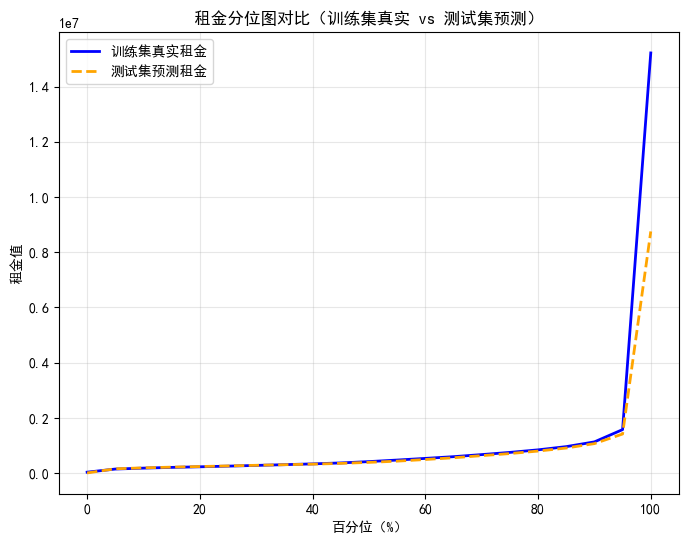

In [31]:
# ===================== 导入必要库（适配大样本XGBoost建模） =====================
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score  # 计算R²
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

# ===================== 修复matplotlib中文显示问题 =====================
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

# ===================== XGBoost建模=====================
# 基础配置（GPU专属）
RANDOM_SEED = 42          
GPU_ID = 0                
EARLY_STOPPING_ROUNDS = 50

# 数据准备（核心修改1：去掉log变换，直接用原始租金数据）
y_train = y_train_rent  # 原始训练集租金
y_val = y_val_rent      # 原始验证集租金

# 转为数组（适配GPU）
X_train_scaled_arr = X_train_scaled.values.astype(np.float32)
X_val_scaled_arr = X_val_scaled.values.astype(np.float32)

# 模型参数（保持不变）
best_params_optimized = {
    'colsample_bytree': 0.75,
    'learning_rate': 0.08,
    'max_depth': 5,
    'subsample': 0.8,
    'reg_alpha': 0.5,
    'reg_lambda': 5.0,
    'gamma': 0.5,
    'max_bin': 256,
    'n_estimators': 1000
}

# 初始化模型
best_xgb_model_optimized = xgb.XGBRegressor(
    **best_params_optimized,
    objective='reg:absoluteerror',
    tree_method='gpu_hist',
    gpu_id=GPU_ID,
    predictor='gpu_predictor',
    random_state=RANDOM_SEED,
    n_jobs=1,
    verbosity=0,
    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
    eval_metric='mae'
)

# 训练模型
eval_set = [(X_train_scaled_arr, y_train), (X_val_scaled_arr, y_val)]
best_xgb_model_optimized.fit(
    X_train_scaled_arr, y_train,
    eval_set=eval_set,
    verbose=False
)

# 预测（核心修改2：训练/验证集预测值立即round(2)）
# 训练集预测 + 非负裁剪 + 保留2位小数
y_train_pred = best_xgb_model_optimized.predict(X_train_scaled_arr)
y_train_pred = np.clip(y_train_pred, 0, None)  # 仅非负裁剪
y_train_pred = np.round(y_train_pred, 2)       # 强制保留2位小数
y_train_true = y_train

# 验证集预测 + 非负裁剪 + 保留2位小数
y_val_pred = best_xgb_model_optimized.predict(X_val_scaled_arr)
y_val_pred = np.clip(y_val_pred, 0, None)      # 仅非负裁剪
y_val_pred = np.round(y_val_pred, 2)           # 强制保留2位小数
y_val_true = y_val

# 评估误差（基于round后的值，结果更贴合实际）
train_mae_optimized = mean_absolute_error(y_train_true, y_train_pred)
train_mae_ratio_optimized = train_mae_optimized / y_train_rent.mean()
train_r2_optimized = r2_score(y_train_true, y_train_pred)

val_mae_optimized = mean_absolute_error(y_val_true, y_val_pred)
val_mae_ratio_optimized = val_mae_optimized / y_train_rent.mean()
val_r2_optimized = r2_score(y_val_true, y_val_pred)

# 输出误差对比（MAE已默认保留2位）
print("="*80)
print("✅ 模型误差详情（训练集+验证集）")
print("="*80)
print(f"训练集MAE：{train_mae_optimized:.2f} | 训练集相对误差：{train_mae_ratio_optimized:.2%} | 训练集R²：{train_r2_optimized:.4f}")
print(f"验证集MAE：{val_mae_optimized:.2f} | 验证集相对误差：{val_mae_ratio_optimized:.2%} | 验证集R²：{val_r2_optimized:.4f}")
print(f"训练/验证MAE差异：{abs(train_mae_optimized - val_mae_optimized):.2f}")
print("="*80)

# 测试集预测（核心修改3：先round(2)再非负裁剪，全链路2位小数）
# 提取测试集ID
test_ids = test_rent['ID'].values if 'ID' in test_rent.columns else np.arange(len(test_rent_scaled))
# 测试集特征数组
test_features_scaled_arr = test_rent_scaled.drop(columns='ID').values.astype(np.float32)

# 预测 + round(2) + 仅非负裁剪
test_pred = best_xgb_model_optimized.predict(test_features_scaled_arr)
test_pred = np.round(test_pred, 2)            # 第一步：强制保留2位小数
test_pred = np.clip(test_pred, 0, None)       # 第二步：仅非负裁剪（不影响小数位数）

# 保存结果（round后的值，CSV仅2位小数）
test_predictions_optimized = pd.DataFrame({
    'ID': test_ids,
    '预测租金': test_pred  # 已提前round，无需重复操作
})
output_path = "XGBoost_租金预测_原始数据+仅非负裁剪.csv"
test_predictions_optimized.to_csv(output_path, index=False, encoding='utf-8-sig')

# 输出测试集统计（强制保留2位）
print("\n📊 测试集预测统计")
print("="*80)
print(f"预测结果保存路径：{output_path}")
print(f"预测租金范围：[{test_predictions_optimized['预测租金'].min():.2f}, {test_predictions_optimized['预测租金'].max():.2f}]")
print(f"预测租金均值：{test_predictions_optimized['预测租金'].mean():.2f}")
print(f"预测租金中位数：{test_predictions_optimized['预测租金'].median():.2f}")
print("="*80)

# 核心修改4：打印前10条时强制格式化显示2位小数
print("🔍 测试集前10条预测结果")
print(test_predictions_optimized.head(10).style.format({'预测租金': '{:.2f}'}))

# ===================== 百分位数展示（用round后的值，保证2位小数） =====================
def print_percentiles(data, name):
    """打印指定数据的关键百分位数（强制2位小数）"""
    percentiles = [0, 5, 25, 50, 75, 90, 95, 99, 100]
    vals = np.percentile(data, percentiles)
    print(f"\n📊 {name} - 百分位分位值")
    print("-"*40)
    for p, v in zip(percentiles, vals):
        print(f"   百分位({p}%)     {v:.2f}")  # 强制2位小数
    print("-"*40)

# 1. 训练集真实租金
print_percentiles(y_train_rent, "训练集真实租金")
# 2. 验证集真实租金
print_percentiles(y_val_true, "验证集真实租金")
# 3. 测试集预测租金（用round后的值）
print_percentiles(test_pred, "测试集预测租金")

# ===================== 分位图（用round后的值，分布更贴合实际） =====================
print("\n📈 绘制分位图（训练集真实租金 vs 测试集预测租金）")
percentiles = np.arange(0, 101, 5)
train_percentile_vals = np.percentile(y_train_rent, percentiles)
test_percentile_vals = np.percentile(test_pred, percentiles)

plt.figure(figsize=(8, 6))  
plt.plot(percentiles, train_percentile_vals, label='训练集真实租金', color='blue', linewidth=2)
plt.plot(percentiles, test_percentile_vals, label='测试集预测租金', color='orange', linewidth=2, linestyle='--')

plt.title('租金分位图对比（训练集真实 vs 测试集预测）', fontsize=12)
plt.xlabel('百分位（%）', fontsize=10)
plt.ylabel('租金值', fontsize=10)
plt.legend()  
plt.grid(alpha=0.3)  
plt.show()

In [29]:
# ===================== 查看租金核心统计信息（适配你的变量命名） =====================
# 1. 统一数据格式（兼容数组/Series）
# 训练集租金（处理极端值后）
if isinstance(y_train_rent, (pd.Series, pd.DataFrame)):
    train_rent = y_train_rent.squeeze()
else:
    train_rent = pd.Series(y_train_rent)

# 验证集租金（处理极端值后）
if isinstance(y_val_rent, (pd.Series, pd.DataFrame)):
    val_rent = y_val_rent.squeeze()
else:
    val_rent = pd.Series(y_val_rent)

# 2. 计算核心统计指标
# 训练集
train_mean = train_rent.mean()       # 均值
train_median = train_rent.median()   # 中位数
train_min = train_rent.min()         # 最小值
train_max = train_rent.max()         # 最大值
train_std = train_rent.std()         # 标准差

# 验证集
val_mean = val_rent.mean()
val_median = val_rent.median()

# 3. 关联MAE误差（优化后）
# 先检查是否已计算优化后的MAE，若未计算则先定义（避免报错）
try:
    val_mae_optimized  # 检查变量是否存在
except NameError:
    val_mae_optimized = 0  # 若未训练，临时赋值为0

train_mae_ratio = val_mae_optimized / train_mean if val_mae_optimized != 0 else 0  # MAE相对误差

# 4. 格式化输出
print("="*80)
print("📊 租金核心统计信息（处理极端值后）")
print("="*80)
print("【训练集】")
print(f"  均值：{train_mean:,.2f}")
print(f"  中位数：{train_median:,.2f}")
print(f"  最小值：{train_min:,.2f} | 最大值：{train_max:,.2f} | 标准差：{train_std:,.2f}")
print(f"  优化后MAE相对误差：{train_mae_ratio:.2%}（若为0则未完成模型训练）")
print("\n【验证集】")
print(f"  均值：{val_mean:,.2f} | 中位数：{val_median:,.2f}")
print("="*80)

📊 租金核心统计信息（处理极端值后）
【训练集】
  均值：598,711.93
  中位数：411,159.79
  最小值：27,553.77 | 最大值：15,230,042.26 | 标准差：634,512.45
  优化后MAE相对误差：12.52%（若为0则未完成模型训练）

【验证集】
  均值：600,527.81 | 中位数：415,285.60


In [30]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader 
from sklearn.metrics import mean_absolute_error

# ========== 1. 基础配置（适配GPU，和XGBoost对齐） ==========
# 设备配置（优先用GPU，和XGBoost的GPU_ID对齐）
device = torch.device(f"cuda:{GPU_ID}" if torch.cuda.is_available() else "cpu")
print(f"\n{'='*80}")
print(f"🚀 开始神经网络训练（设备：{device} | 特征数：{X_train_scaled_arr.shape[1]}）")
print(f"{'='*80}")

# 训练超参数（适配200+特征）
BATCH_SIZE = 256 if torch.cuda.is_available() else 64  # GPU用256，CPU用64
LEARNING_RATE = 0.001
EPOCHS = 100
PATIENCE = 10  # 早停耐心值
DROPOUT_RATE = 0.2  # 防止过拟合

# ========== 2. 构建数据集类（适配现有数组格式） ==========
class RentDataset(Dataset):
    def __init__(self, X, y):
        # 核心修复：强制转为numpy数组（兼容Series/数组/列表）
        X_arr = np.array(X).astype(np.float32) if isinstance(X, pd.Series) else X
        y_arr = np.array(y).astype(np.float32) if isinstance(y, pd.Series) else y
        
        # 转为torch张量，适配device
        self.X = torch.tensor(X_arr, dtype=torch.float32).to(device)
        self.y = torch.tensor(y_arr, dtype=torch.float32).to(device)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 构建DataLoader（训练/验证/测试集）
train_dataset = RentDataset(X_train_scaled_arr, y_train_log)
val_dataset = RentDataset(X_val_scaled_arr, y_val_log)
test_dataset = RentDataset(test_features_scaled_arr, np.zeros(len(test_features_scaled_arr)))  # 测试集标签占位

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ========== 3. 构建神经网络模型（适配200+特征） ==========
class RentRegressionNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512, 256, 128], dropout_rate=0.2):
        super().__init__()
        # 构建隐藏层（200+特征用512→256→128，兼顾拟合能力和速度）
        layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, dim))
            layers.append(nn.BatchNorm1d(dim))  # 加速训练，稳定梯度
            layers.append(nn.ReLU())  # 非线性激活
            layers.append(nn.Dropout(dropout_rate))  # 防止过拟合
            prev_dim = dim
        # 输出层（回归任务：单节点，无激活）
        layers.append(nn.Linear(prev_dim, 1))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x).squeeze()  # 压缩维度：(batch,1)→(batch,)

# 初始化模型（input_dim=200+特征数）
input_dim = X_train_scaled_arr.shape[1]
model = RentRegressionNN(
    input_dim=input_dim,
    hidden_dims=[512, 256, 128],
    dropout_rate=DROPOUT_RATE
).to(device)

# ========== 4. 训练配置（和XGBoost评估对齐） ==========
criterion = nn.MSELoss()  # 回归任务核心损失（对数空间）
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)  # 学习率衰减

# 早停+最优模型保存
best_val_loss = float('inf')
stop_count = 0
best_model_path = "best_rent_nn_model.pth"

# ========== 5. 模型训练 ==========
print("\n📈 神经网络训练日志（每10轮打印一次）")
print("-"*80)
for epoch in range(EPOCHS):
    # 训练阶段
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()  # 清空梯度
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)
    
    # 验证阶段
    model.eval()
    val_loss = 0.0
    with torch.no_grad():  # 禁用梯度计算，提速
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(val_loader.dataset)
    
    # 学习率衰减
    scheduler.step(val_loss)
    
    # 早停判断
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)  # 保存最优模型
        stop_count = 0
    else:
        stop_count += 1
        if stop_count >= PATIENCE:
            print(f"⚠️ 早停触发！第{epoch+1}轮验证集损失未下降，停止训练")
            break
    
    # 打印训练日志
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] | 训练损失：{train_loss:.4f} | 验证损失：{val_loss:.4f}")

# ========== 6. 加载最优模型，预测+反变换（和XGBoost对齐） ==========
# 加载最优模型
model.load_state_dict(torch.load(best_model_path))
model.eval()

# 训练集预测+反变换
train_pred_log = []
with torch.no_grad():
    for X_batch, _ in DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False):
        pred = model(X_batch)
        train_pred_log.extend(pred.cpu().numpy())
train_pred_log = np.array(train_pred_log)
train_pred_nn = np.expm1(train_pred_log)  # 反对数变换
train_true_nn = np.expm1(y_train_log)

# 验证集预测+反变换
val_pred_log = []
with torch.no_grad():
    for X_batch, _ in DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False):
        pred = model(X_batch)
        val_pred_log.extend(pred.cpu().numpy())
val_pred_log = np.array(val_pred_log)
val_pred_nn = np.expm1(val_pred_log)
val_true_nn = np.expm1(y_val_log)

# 测试集预测+反变换+极端值裁剪（和XGBoost完全对齐）
test_pred_log = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        pred = model(X_batch)
        test_pred_log.extend(pred.cpu().numpy())
test_pred_log = np.array(test_pred_log)
test_pred_nn = np.expm1(test_pred_log)
test_pred_nn = np.clip(test_pred_nn, min_rent, max_rent)  # 裁剪极端值

# ========== 7. 评估指标（和XGBoost格式完全对齐） ==========
# 训练集指标
train_mae_nn = mean_absolute_error(train_true_nn, train_pred_nn)
train_mae_ratio_nn = train_mae_nn / y_train_rent.mean()

# 验证集指标
val_mae_nn = mean_absolute_error(val_true_nn, val_pred_nn)
val_mae_ratio_nn = val_mae_nn / y_train_rent.mean()

# 输出对比结果
print("\n" + "="*80)
print("✅ 神经网络 vs XGBoost 误差对比")
print("="*80)
# XGBoost结果
print(f"【XGBoost】")
print(f"  训练集MAE：{train_mae_optimized:.2f} | 相对误差：{train_mae_ratio_optimized:.2%}")
print(f"  验证集MAE：{val_mae_optimized:.2f} | 相对误差：{val_mae_ratio_optimized:.2%}")
# 神经网络结果
print(f"\n【神经网络】")
print(f"  训练集MAE：{train_mae_nn:.2f} | 相对误差：{train_mae_ratio_nn:.2%}")
print(f"  验证集MAE：{val_mae_nn:.2f} | 相对误差：{val_mae_ratio_nn:.2%}")
# 差异对比
print(f"\n【差异】")
print(f"  验证集MAE差异：{abs(val_mae_nn - val_mae_optimized):.2f}")
print(f"  神经网络相对误差{'优于' if val_mae_ratio_nn < val_mae_ratio_optimized else '劣于'}XGBoost：{abs(val_mae_ratio_nn - val_mae_ratio_optimized):.2%}")
print("="*80)

# ========== 8. 保存神经网络预测结果（和XGBoost格式一致） ==========
test_predictions_nn = pd.DataFrame({
    'ID': test_ids,
    '预测租金': test_pred_nn.round(2)
})
nn_output_path = "NN_租金预测_优化版.csv"
test_predictions_nn.to_csv(nn_output_path, index=False, encoding='utf-8-sig')

# 输出测试集统计（和XGBoost对齐）
print("\n📊 神经网络测试集预测统计")
print("="*80)
print(f"预测结果保存路径：{nn_output_path}")
print(f"预测租金范围：[{test_predictions_nn['预测租金'].min():.2f}, {test_predictions_nn['预测租金'].max():.2f}]")
print(f"预测租金均值：{test_predictions_nn['预测租金'].mean():.2f}")
print(f"预测租金中位数：{test_predictions_nn['预测租金'].median():.2f}")
print("="*80)
print("🔍 神经网络测试集前10条预测结果")
print(test_predictions_nn.head(10))


🚀 开始神经网络训练（设备：cuda:0 | 特征数：204）


NameError: name 'y_train_log' is not defined

In [ ]:
# 1. 加载XGBoost预测结果（核心：仅保留文件加载方式）
xgb_pred_df = pd.read_csv("XGBoost_租金预测_优化版.csv")
xgb_test_pred = xgb_pred_df['预测租金'].values  # 测试集XGBoost预测值
xgb_train_pred = best_xgb_model_optimized.predict(X_train_scaled_arr)  # 训练集XGBoost预测
xgb_train_pred = np.expm1(xgb_train_pred)
xgb_val_pred = best_xgb_model_optimized.predict(X_val_scaled_arr)      # 验证集XGBoost预测
xgb_val_pred = np.expm1(xgb_val_pred)

# 2. 加权融合（0.8 XGB + 0.2 ANN）
train_pred_ensemble = 0.8 * xgb_train_pred + 0.2 * train_pred_nn
val_pred_ensemble = 0.8 * xgb_val_pred + 0.2 * val_pred_nn
test_pred_ensemble = 0.8 * xgb_test_pred + 0.2 * test_pred_nn
test_pred_ensemble = np.clip(test_pred_ensemble, min_rent, max_rent)  # 裁剪极端值

# 3. 评估集成效果
train_mae_ensemble = mean_absolute_error(train_true_nn, train_pred_ensemble)
train_mae_ratio_ensemble = train_mae_ensemble / y_train_rent.mean()
val_mae_ensemble = mean_absolute_error(val_true_nn, val_pred_ensemble)
val_mae_ratio_ensemble = val_mae_ensemble / y_train_rent.mean()

# 4. 输出对比结果
print("📊 集成学习 vs XGBoost vs ANN 误差对比")
print("-"*80)
print(f"【XGBoost】  训练MAE：{train_mae_optimized:.2f} | 验证MAE：{val_mae_optimized:.2f}")
print(f"【ANN】      训练MAE：{train_mae_nn:.2f} | 验证MAE：{val_mae_nn:.2f}")
print(f"【集成学习】 训练MAE：{train_mae_ensemble:.2f} | 验证MAE：{val_mae_ensemble:.2f}")
print(f"✅ 集成收益：验证MAE降低 {val_mae_optimized - val_mae_ensemble:.2f}")
print("-"*80)

# 5. 保存集成结果
ensemble_predictions = pd.DataFrame({
    'ID': test_ids,
    '预测租金': test_pred_ensemble.round(2)
})
ensemble_predictions.to_csv("集成学习_租金预测.csv", index=False, encoding='utf-8-sig')

# 6. 输出核心统计
print(f"\n📈 集成结果保存路径：集成学习_租金预测.csv")
print(f"预测租金范围：[{ensemble_predictions['预测租金'].min():.2f}, {ensemble_predictions['预测租金'].max():.2f}]")
print(f"预测租金均值：{ensemble_predictions['预测租金'].mean():.2f}")
print("="*80)